In [1]:
import os
import random
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.random import set_seed
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Input, Conv2D, ELU, BatchNormalization,concatenate, \
                                    Add, GlobalAveragePooling2D, Flatten, Dense, MaxPooling2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model, load_model

In [2]:
radom_seed = 0
random.seed(radom_seed)
numpy_seed = 0
np.random.seed(numpy_seed)
tensorflow_seed = 0
set_seed(tensorflow_seed)

In [3]:
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, N_CLASSES = 32,32,3,10
SAVE_DIRECTORY = "./cifar10/numpy_data/"
MODEL_DIR = "./models/"

In [4]:
if "models" not in os.listdir("./"):
    os.makedirs(MODEL_DIR)

In [5]:
def elu_bn(inputs):
    """
    A function for computing elu then batch normalization
    """
    elu = ELU()(inputs)
    bn = BatchNormalization()(elu)
    return bn

def residual_block(x, filters, kernel_size):
    """
    A function to create residual block
    """
    x2 = Conv2D(kernel_size=kernel_size,
               strides= 1,
               filters=filters,
               padding="same")(x)
    x2 = elu_bn(x2)
    y = Conv2D(kernel_size=kernel_size,
               strides= 1,
               filters=filters,
               padding="same")(x2)
    y = elu_bn(y)
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)
    out = Add()([x2, y])
    out = elu_bn(out)
    return out

def create_net(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, N_CLASSES,
               filters, kernels, learning_rate):
    """
    A function to create net
    """
    X = Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    n_layers = len(kernels)
    for i in range(n_layers):
        if i ==0:
            layer = residual_block(X, filters[i], kernels[i])
            layer = MaxPooling2D((2,2), strides=(2,2), padding='same')(layer)            
        elif i == n_layers-1:
            layer = residual_block(layer, filters[i], kernels[i])
        else:
            layer = residual_block(layer, filters[i], kernels[i])
            layer = MaxPooling2D((2,2), strides=(2,2), padding='same')(layer)
            
    Y = GlobalAveragePooling2D()(layer)
    Y = Dense(128, activation='elu')(Y)
    Y = BatchNormalization()(Y)
    Y = Dense(N_CLASSES, activation='softmax')(Y)
    
    model = Model(inputs=X, outputs=Y)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss=SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model

In [6]:
clear_session()
num_filters = 64
kernels = [3,3,3,3]
filters = [30,90,180,360]
learning_rate = (1e-3)*0.5
model = create_net(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, N_CLASSES,
                   filters, kernels, learning_rate)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 30)   840         input_1[0][0]                    
__________________________________________________________________________________________________
elu (ELU)                       (None, 32, 32, 30)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 30)   120         elu[0][0]                        
______________________________________________________________________________________________

In [16]:
X_train = np.load(SAVE_DIRECTORY+"X_train.npy")
X_valid = np.load(SAVE_DIRECTORY+"X_valid.npy")
Y_train = np.load(SAVE_DIRECTORY+"Y_train.npy")
Y_valid = np.load(SAVE_DIRECTORY+"Y_valid.npy")

In [8]:
def train_model(model, epochs, batch_size, checkpoint_cb, 
                X_train, Y_train, X_valid, Y_valid):
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size = batch_size,
                        validation_data = (X_valid, Y_valid), 
                        callbacks=[checkpoint_cb])
    return model, history 

In [9]:
epochs = 100
batch_size = 1024
checkpoint_cb = ModelCheckpoint(MODEL_DIR+"model.h5", monitor = 'val_accuracy', 
                                save_freq = "epoch", save_best_only=True, 
                                mode = "max")
model, history = train_model(model, epochs, batch_size, checkpoint_cb, 
                             X_train, Y_train, X_valid, Y_valid)

Epoch 1/100
94/94 [==============================] - 46s 486ms/step - loss: 1.4662 - accuracy: 0.4828 - val_loss: 2.7585 - val_accuracy: 0.2105
Epoch 2/100
94/94 [==============================] - 41s 441ms/step - loss: 0.9542 - accuracy: 0.6645 - val_loss: 2.1126 - val_accuracy: 0.2245
Epoch 3/100
94/94 [==============================] - 41s 441ms/step - loss: 0.6974 - accuracy: 0.7573 - val_loss: 1.5256 - val_accuracy: 0.4575
Epoch 4/100
94/94 [==============================] - 42s 448ms/step - loss: 0.5099 - accuracy: 0.8240 - val_loss: 1.1006 - val_accuracy: 0.6260
Epoch 5/100
94/94 [==============================] - 42s 451ms/step - loss: 0.3423 - accuracy: 0.8833 - val_loss: 1.1649 - val_accuracy: 0.6545
Epoch 6/100
94/94 [==============================] - 42s 449ms/step - loss: 0.2226 - accuracy: 0.9249 - val_loss: 0.9575 - val_accuracy: 0.7340
Epoch 7/100
94/94 [==============================] - 42s 449ms/step - loss: 0.1471 - accuracy: 0.9511 - val_loss: 1.2579 - val_accuracy:

94/94 [==============================] - 41s 437ms/step - loss: 0.0052 - accuracy: 0.9983 - val_loss: 1.0163 - val_accuracy: 0.8200
Epoch 58/100
94/94 [==============================] - 41s 437ms/step - loss: 0.0051 - accuracy: 0.9981 - val_loss: 1.0845 - val_accuracy: 0.8225
Epoch 59/100
94/94 [==============================] - 41s 438ms/step - loss: 0.0060 - accuracy: 0.9979 - val_loss: 1.1017 - val_accuracy: 0.8155
Epoch 60/100
94/94 [==============================] - 41s 437ms/step - loss: 0.0048 - accuracy: 0.9984 - val_loss: 1.0949 - val_accuracy: 0.8130
Epoch 61/100
94/94 [==============================] - 41s 437ms/step - loss: 0.0049 - accuracy: 0.9983 - val_loss: 1.1031 - val_accuracy: 0.8215
Epoch 62/100
94/94 [==============================] - 41s 440ms/step - loss: 0.0050 - accuracy: 0.9983 - val_loss: 1.0889 - val_accuracy: 0.8155
Epoch 63/100
94/94 [==============================] - 42s 444ms/step - loss: 0.0096 - accuracy: 0.9969 - val_loss: 1.4399 - val_accuracy: 0.775

In [17]:
X_train, Y_train = None, None
X_test = np.load(SAVE_DIRECTORY+"X_test.npy")
Y_test = np.load(SAVE_DIRECTORY+"Y_test.npy")

In [11]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [12]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

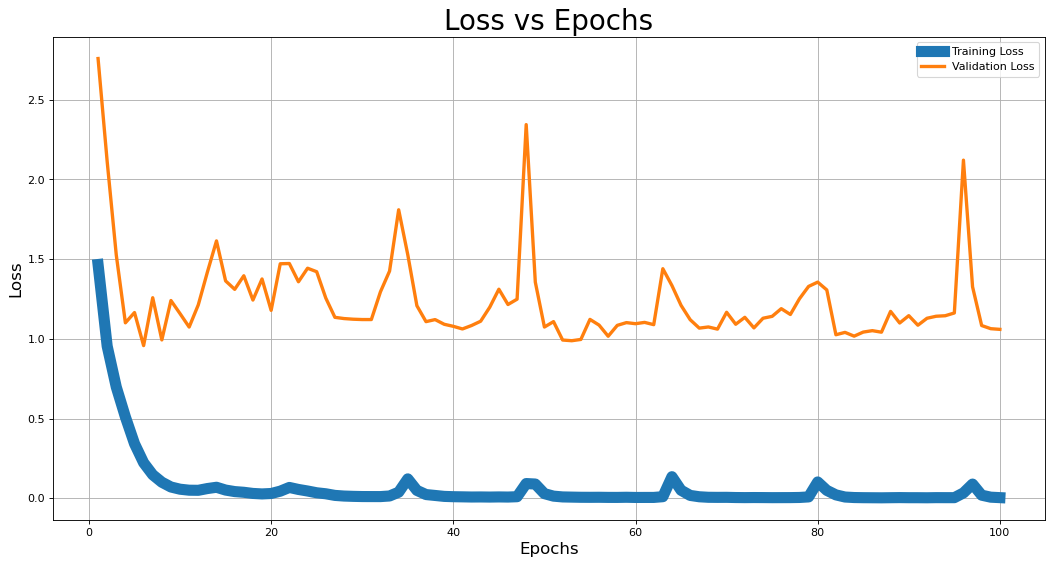

In [13]:
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss,  label='Training Loss', linewidth = 10.0)
plt.plot(epochs, val_loss,  label='Validation Loss', linewidth = 3)
plt.title('Loss vs Epochs', fontsize = 25)
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.legend()
plt.grid(True)
plt.show()

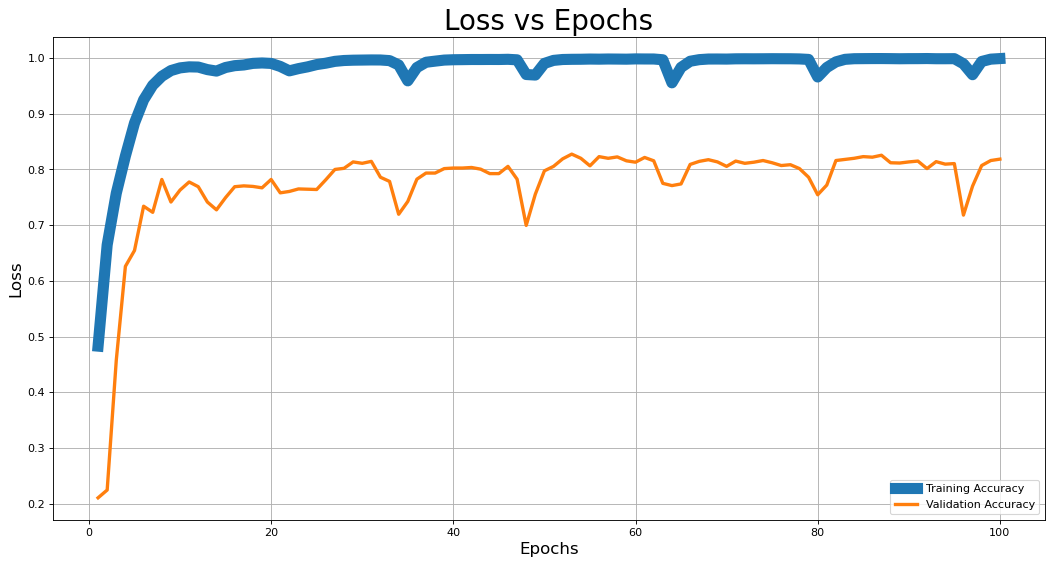

In [14]:
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc,  label='Training Accuracy', linewidth = 10.0)
plt.plot(epochs, val_acc,  label='Validation Accuracy', linewidth = 3)
plt.title('Loss vs Epochs', fontsize = 25)
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.legend()
plt.grid(True)
plt.show()

In [18]:
model = load_model(MODEL_DIR+"model.h5")
valid_accuracy = accuracy_score(Y_valid, np.argmax(model.predict(X_valid), axis = -1))
test_accuracy = accuracy_score(Y_test, np.argmax(model.predict(X_test), axis = -1))
print("Valid accuracy:",valid_accuracy)
print("Test accuracy:",test_accuracy)

Valid accuracy: 0.8275
Test accuracy: 0.8024
